In [1]:
#Tous les codes sont basés sur l'environnement suivant
#python 3.7
#opencv 3.1.0
#pytorch 1.4.0

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import pickle
import random
from PIL import Image
import sys

In [2]:
#Les fonctions dans ce bloc ne sont pas utilisées par le réseau, mais certaines fonctions d'outils


def tensor_imshow(im_tensor,cannel):
    b,c,h,w=im_tensor.shape
    if c==1:
        plt.imshow(im_tensor.squeeze().detach().numpy())
    else:
        plt.imshow(im_tensor.squeeze().detach().numpy()[cannel,:])

#    Obtenez des données d'entraînement
#    frag,vt=get_training_fragment(frag_size,image)
#    frag est un patch carrée de taille (frag_size*frag_size) a partir du image(Son emplacement est aléatoire)
#    vt est la vérité terrain de la forme Dirac.
def get_training_fragment(frag_size,im):
    h,w,c=im.shape
    n=random.randint(0,int(h/frag_size)-1)
    m=random.randint(0,int(w/frag_size)-1) 
    shape=frag_size/4
    vt_h=math.ceil((h+1)/shape)
    vt_w=math.ceil((w+1)/shape)
    vt=np.zeros([vt_h,vt_w])
    vt_h_po=round((vt_h-1)*(n*frag_size/(h-1)+(n+1)*frag_size/(h-1))/2)
    vt_w_po=round((vt_w-1)*(m*frag_size/(w-1)+(m+1)*frag_size/(w-1))/2)
    vt[vt_h_po,vt_w_po]=1
    vt = np.float32(vt)
    vt=torch.from_numpy(vt.reshape(1,1,vt_h,vt_w))
    
    return im[n*frag_size:(n+1)*frag_size,m*frag_size:(m+1)*frag_size,:],vt

#    Charger un fragment d'entrainement
#    Les fragments sont chargés comme des images et les véritées terrain sont générées
def load_training_fragment(frag_path,vt_path,using_cuda):
    frag=cv2.imread(im_path)
    with open(vt_path, 'r') as f:
        data_vt = f.readlines()
    
    if using_cuda:
        frag=frag.cuda()
        vt=vt.cuda()
    

#    Cette fonction convertit l'image en variable de type Tensor.
#    Toutes les données de calcul du réseau sont de type Tensor
#    Img.shape=[Height,Width,Channel]
#    Tensor.shape=[Batch,Channel,Height,Width]
def img2tensor(im):
    im=np.array(im,dtype="float32")
    tensor_cv = torch.from_numpy(np.transpose(im, (2, 0, 1)))
    im_tensor=tensor_cv.unsqueeze(0)
    return im_tensor

#   Trouvez les coordonnées de la valeur maximale dans une carte de corrélation
#   x,y=show_coordonnee(carte de corrélation)
def show_coordonnee(position_pred):
    map_corre=position_pred.squeeze().detach().numpy()
    h,w=map_corre.shape
    max_value=map_corre.max()
    coordonnee=np.where(map_corre==max_value)
    return coordonnee[0].mean()/h,coordonnee[1].mean()/w

#   Filtrer les patchs en fonction du nombre de pixels noirs dans le patch
#   Si seuls les pixels non noirs sont plus grands qu'une certaine proportion(seuillage), revenez à True, sinon False
def test_fragment32_32(frag,seuillage):
    a=frag[:,:,0]+frag[:,:,1]+frag[:,:,2]
    mask = (a == 0)
    arr_new = a[mask]
    if arr_new.size/a.size<=(1-seuillage):
        return True
    else:
        return False
    
#    Ces deux fonctions permettent de sauvegarder le réseau dans un fichier
#    ou de load le réseau stocké à partir d'un fichier
def save_net(file_path,net):
    pkl_file = open(file_path, 'wb')
    pickle.dump(net,pkl_file)
    pkl_file.close()
def load_net(file_path):   
    pkl_file = open(file_path, 'rb')
    net= pickle.load(pkl_file)
    pkl_file.close()
    return net

In [6]:
#   Créer un poids de type DeepMatch comme valeur initiale de Conv1 (non obligatoire)
def ini():
    kernel=torch.zeros([8,3,3,3])
    array_0=np.array([[1,2,1],[0,0,0],[-1,-2,-1]],dtype='float32')
    array_1=np.array([[2,1,0],[1,0,-1],[0,-1,-2]],dtype='float32')
    array_2=np.array([[1,0,-1],[2,0,-2],[1,0,-1]],dtype='float32')
    array_3=np.array([[0,-1,-2],[1,0,-1],[2,1,0]],dtype='float32')
    array_4=np.array([[-1,-2,-1],[0,0,0],[1,2,1]],dtype='float32')
    array_5=np.array([[-2,-1,0],[-1,0,1],[0,1,2]],dtype='float32')
    array_6=np.array([[-1,0,1],[-2,0,2],[-1,0,1]],dtype='float32')
    array_7=np.array([[0,1,2],[-1,0,1],[-2,-1,0]],dtype='float32')
    for i in range(3):
        kernel[0,i,:]=torch.from_numpy(array_0)
        kernel[1,i,:]=torch.from_numpy(array_1)
        kernel[2,i,:]=torch.from_numpy(array_2)
        kernel[3,i,:]=torch.from_numpy(array_3)
        kernel[4,i,:]=torch.from_numpy(array_4)
        kernel[5,i,:]=torch.from_numpy(array_5)
        kernel[6,i,:]=torch.from_numpy(array_6)
        kernel[7,i,:]=torch.from_numpy(array_7)
    return torch.nn.Parameter(kernel,requires_grad=True) 

#   Calculer le poids initial de la couche convolutive add
#   n, m signifie qu'il y a n * m sous-patches dans le patch d'entrée
#   Par exemple, le patch d'entrée est 16 * 16, pour les patchs 4 * 4 de la première couche, n = 4, m = 4
#   pour les patchs 8 * 8 de la deuxième couche, n = 2, m = 2
def kernel_add_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n/2)*int(m/2)
    for i in range(int(n/2)):
        for j in range(int(m/2)):
            kernel_add=np.zeros([1,input_canal],dtype='float32')
            kernel_add[0,i*2*m+j*2]=1
            kernel_add[0,i*2*m+j*2+1]=1
            kernel_add[0,(i*2+1)*m+j*2]=1
            kernel_add[0,(i*2+1)*m+j*2+1]=1
            if i==0 and j==0:
                add=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
            else:
                add_=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
                add=torch.cat((add,add_),0)
    return torch.nn.Parameter(add,requires_grad=False) 

#   Calculer le poids initial de la couche convolutive shift
#   shift+add Peut réaliser l'étape de l'agrégation
#   Voir ci-dessus pour les paramètres n et m. 
#   Pour des étapes plus détaillées, veuillez consulter mon rapport de stage
def kernel_shift_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n*m)
    
    kernel_shift=torch.zeros([output_canal,input_canal,3,3])
    
    array_0=np.array([[1,0,0],[0,0,0],[0,0,0]],dtype='float32')
    array_1=np.array([[0,0,1],[0,0,0],[0,0,0]],dtype='float32')
    array_2=np.array([[0,0,0],[0,0,0],[1,0,0]],dtype='float32')
    array_3=np.array([[0,0,0],[0,0,0],[0,0,1]],dtype='float32')
    
    kernel_shift_0=torch.from_numpy(array_0)
    kernel_shift_1=torch.from_numpy(array_1)
    kernel_shift_2=torch.from_numpy(array_2)
    kernel_shift_3=torch.from_numpy(array_3)
    
    
    for i in range(n):
        for j in range(m):
            if i==0 and j==0:
                kernel_shift[0,0,:]=kernel_shift_0
            else:
                if i%2==0 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_0
                if i%2==0 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_1
                if i%2==1 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_2
                if i%2==1 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_3
                    
    return torch.nn.Parameter(kernel_shift,requires_grad=False) 

#   Trouvez le petit patch(4 * 4) dans la n ème ligne et la m ème colonne du patch d'entrée
#   Ceci est utilisé pour calculer la convolution et obtenir la carte de corrélation
def get_patch(fragment,psize,n,m):
    return fragment[:,:,n*psize:(n+1)*psize,m*psize:(m+1)*psize]
###################################################################################################################
class Net(nn.Module):
    def __init__(self,frag_size,psize):
        super(Net, self).__init__()
       
        h_fr=frag_size
        w_fr=frag_size
        
        n=int(h_fr/psize) #    n*m patches dans le patch d'entrée
        m=int(w_fr/psize)
        
        self.conv1 = nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1)
        #    Si vous souhaitez initialiser Conv1 avec les poids de DeepMatch, exécutez la ligne suivante
        #    self.conv1.weight=ini()
        self.Relu = nn.ReLU(inplace=True)
        self.maxpooling=nn.MaxPool2d(3,stride=2, padding=1)
        
        self.shift1=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
        self.shift1.weight=kernel_shift_ini(n,m)
        self.add1 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
        self.add1.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:#   Si n=m=1，Notre réseau n'a plus besoin de plus de couches pour agréger les cartes de corrélation
            self.shift2=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift2.weight=kernel_shift_ini(n,m)
            self.add2 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add2.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            self.shift3=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift3.weight=kernel_shift_ini(n,m)
            self.add3 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add3.weight=kernel_add_ini(n,m)
              
    def get_descripteur(self,img,using_cuda):
        #   Utilisez Conv1 pour calculer le descripteur,
        descripteur_img=self.Relu(self.conv1(img))
        b,c,h,w=descripteur_img.shape
        couche_constante=0.5*torch.ones([1,1,h,w])
        if using_cuda:
            couche_constante=couche_constante.cuda()
        #    Ajouter une couche constante pour éviter la division par 0 lors de la normalisation
        descripteur_img=torch.cat((descripteur_img,couche_constante),1)
        #    la normalisation
        descripteur_img_norm=descripteur_img/torch.norm(descripteur_img,dim=1)
        return descripteur_img_norm
    
    def forward(self,img,frag,using_cuda):
        psize=4
        #   Utilisez Conv1 pour calculer le descripteur,
        descripteur_input1=self.get_descripteur(img,using_cuda)
        descripteur_input2=self.get_descripteur(frag,using_cuda)
        
        b,c,h,w=frag.shape
        n=int(h/psize)
        m=int(w/psize)
        
        #######################################
        #    Calculer la carte de corrélation par convolution pour les n*m patchs plus petit.
        for i in range(n):
            for j in range(m):
                if i==0 and j==0:
                    map_corre=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                else:
                    a=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                    map_corre=torch.cat((map_corre,a),1)
        ########################################
        #    Étape de polymérisation
        map_corre=self.maxpooling(map_corre)
        map_corre=self.shift1(map_corre)
        map_corre=self.add1(map_corre)
        
        #########################################
        #    Répétez l'étape d'agrégation jusqu'à obtenir le graphique de corrélation du patch d'entrée
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift2(map_corre)
            map_corre=self.add2(map_corre)
        
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift3(map_corre)
            map_corre=self.add3(map_corre)
        
        
        b,c,h,w=map_corre.shape
        #   Normalisation de la division par maximum
        map_corre=map_corre/(map_corre.max())
        #   Normalisation SoftMax
        #map_corre=(F.softmax(map_corre.reshape(1,1,h*w,1),dim=2)).reshape(b,c,h,w)
        return map_corre

In [4]:
def run_net(net,img,frag,frag_size,using_cuda):
    h,w,c=frag.shape
    n=int(h/frag_size)
    m=int(w/frag_size)
    frag_list=[]
    #####################################
    #    Obtenez des patchs carrés des fragments et mettez-les dans la frag_list
    for i in range(n):
        for j in range(m):
            frag_32=frag[i*frag_size:(i+1)*frag_size,j*frag_size:(j+1)*frag_size]
            if test_fragment32_32(frag_32,0.6):
                frag_list.append(frag_32)
    img_tensor=img2tensor(img)
    ######################################
    if using_cuda:
        img_tensor=img_tensor.cuda()
        
    coordonnee_list=[]
    #######################################
    #    Utilisez le réseau pour calculer les positions de tous les patchs dans frag_list[]
    #    Mettez le résultat du calcul dans coordonnee_list[]
    for i in range(len(frag_list)):
        frag_tensor=img2tensor(frag_list[i])
        if using_cuda:
            frag_tensor=frag_tensor.cuda()
        res=net.forward(img_tensor,frag_tensor,using_cuda)
        if using_cuda:
            res=res.cpu()
        po_h,po_w=show_coordonnee(res)
        coordonnee_list.append([po_h,po_w])
    h_img,w_img,c=img.shape
    position=[]
    for i in range(len(coordonnee_list)):
        x=int(round(h_img*coordonnee_list[i][0]))
        y=int(round(w_img*coordonnee_list[i][1]))
        position.append([x,y])
    return position

In [8]:
if __name__=='__main__':
    
    #     La taille du patch d'entrée est de 16*16
    frag_size=16
    #     La taille du plus petit patch dans réseau est de 4 *4 fixée
    psize=4
    using_cuda=True
    
    
    net=Net(frag_size,psize)
    
    #     Pour chaque fresque, le nombre d'itérations est de 1000
    itera=1000
    
    if using_cuda:
        net=net.cuda()
    
    #    Choisissez l'optimiseur et la fonction de coût
    optimizer = torch.optim.Adam(net.parameters())
    loss_func = torch.nn.MSELoss()
    
    #    Dans le processus d'apprentissage du réseau,le changement d'erreur est placé dans loss_value=[] 
    #    et le changement de Conv1 poids est placé dans para_value[]
    loss_value=[]
    para_value=[]
    ####################################################training_net
    
    #Les données d'entraînement sont 6 fresques
    N_fresque = 6
    for fresque_id in range(N_fresque):
        im_path="./training_data/fresque{}.ppm".format(fresque_id)
        img_training=cv2.imread(im_path)
        h,w,c=img_training.shape
        
        #    Si la peinture murale est trop grande, sous-échantillonnez-la et rétrécissez-la
        while h*w>(1240*900):
            img_training=cv2.resize(img_training,(int(h/2),int(w/2)),interpolation=cv2.INTER_CUBIC)
            h,w,c=img_training.shape
        im_tensor=img2tensor(img_training)
        
        if using_cuda:
            im_tensor=im_tensor.cuda()
        for i in range(itera):
            #     Tous les 100 cycles, enregistrez le changement de poids
            if i%100==0:
                para=net.conv1.weight
                para=para.detach().cpu()
                para_value.append(para)
            frag,vt=get_training_fragment(frag_size,img_training)
            frag_tensor=img2tensor(frag)
            if using_cuda:
                vt=vt.cuda()
                frag_tensor=frag_tensor.cuda()
            #     Utilisez des patchs et des fresques de données d'entraînement pour faire fonctionner le réseau
            frag_pred=net.forward(im_tensor,frag_tensor,using_cuda)
            b,c,h,w=vt.shape
            #    Utilisez la fonction de coût pour calculer l'erreur
            err_=loss_func(vt,frag_pred)
            #    Utilisez l'optimiseur pour ajuster le poids de Conv1
            optimizer.zero_grad()
            err_.backward(retain_graph=True)
            optimizer.step()
            
            loss_value.append(err_.tolist())
    
            del frag_tensor,frag_pred,err_,vt
            torch.cuda.empty_cache()
            
    #    sauvegarder le réseau dans le fichier "net_trainned6000"
    file_path="./net_trainned6000"
    save_net(file_path,net)

In [7]:
len(loss_value)

6000

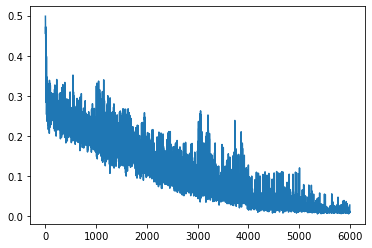

In [11]:
plt.plot(loss_value)

In [12]:
file_path="./net_trainned6000"
save_net(file_path,net)